<a href="https://colab.research.google.com/github/Marina-Liu/Contrast-enhanced-MRI-Synthesis/blob/master/UNet_Osman_2021DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Tumor_enhancement
%cd ./Contrast-enhanced-MRI-Synthesis

/content/drive/MyDrive/Tumor_enhancement
/content/drive/MyDrive/Tumor_enhancement/Contrast-enhanced-MRI-Synthesis


Used memory to store img_sc:  68.115234375 MB
Used memory to store img_sc:  68.115234375 MB
Used memory to store img_sc:  68.115234375 MB
Used memory to store img_tg:  68.115234375 MB


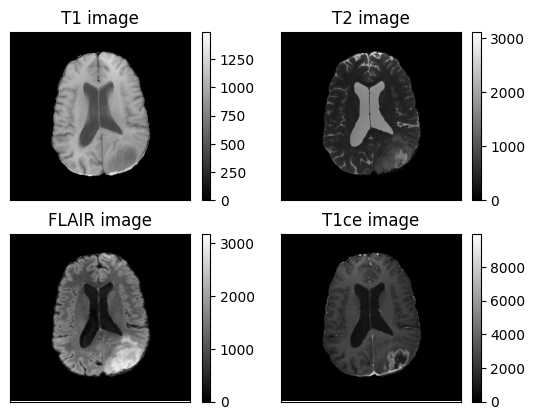

In [3]:
# Deep Learning for Contrast-Enhanced T1 MR Image Synthesis
# @author: Alexander F.I. Osman, April 2023

"""
PART I: TRAINING THE MODEL

This code demonstrates a 3D Res U-Net architecture for contrast-enhanced MR image
synthesis from contrast-free image.

Architectures: 3D U-Net

Dataset: BRATS'2021 challenge dataset.

The training process goes through the following steps:
1. Load the data
2. Pre-process the data (clean the data, resize, normalize, etc.)
3. Build the model architecture (3D U-Net)
4. Train and validate the model for image translations
"""

###############################################################################
# 1. LOADING A SAMPLE DATA SET AND VISUALIZE ##################################
###############################################################################

import numpy as np
import nibabel as nib
import matplotlib
matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# Initial understanding of the dataset.
# Read source images (T1)
HOME_DIR = './Data/'
dataset_path = HOME_DIR + 'MICCAI_BraTS_2021_Data_Training/'
img_t1 = (dataset_path + 'BraTS2021_00071/BraTS2021_00071_t1.nii.gz')
img_t1 = nib.load(img_t1).get_fdata()
img_t1 = np.rot90(np.array(img_t1), k=3)

# Read source images (T2)
img_t2 = (dataset_path + 'BraTS2021_00071/BraTS2021_00071_t2.nii.gz')
img_t2 = nib.load(img_t2).get_fdata()
img_t2 = np.rot90(np.array(img_t2), k=3)

# Read source images (FLAIR)
img_fl = (dataset_path + 'BraTS2021_00071/BraTS2021_00071_flair.nii.gz')
img_fl = nib.load(img_fl).get_fdata()
img_fl = np.rot90(np.array(img_fl), k=3)

# Read target images (T1ce)
img_t1ce = (dataset_path + 'BraTS2021_00071/BraTS2021_00071_t1ce.nii.gz')
img_t1ce = nib.load(img_t1ce).get_fdata()
img_t1ce = np.rot90(np.array(img_t1ce), k=3)

print("Used memory to store img_sc: ", img_t1.nbytes/(1024*1024), "MB")
print("Used memory to store img_sc: ", img_t2.nbytes/(1024*1024), "MB")
print("Used memory to store img_sc: ", img_fl.nbytes/(1024*1024), "MB")
print("Used memory to store img_tg: ", img_t1ce.nbytes/(1024*1024), "MB")

# Plot
slice_numb = 82
#slice_numb = random.randint(0, img_t1.shape[2])
plt.subplot(221)
plt.imshow(img_t1[:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight')
plt.xticks([])
plt.yticks([])
plt.subplot(222)
plt.imshow(img_t2[:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T2 image'), plt.axis('tight')
plt.xticks([])
plt.yticks([])
plt.subplot(223)
plt.imshow(img_fl[:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('FLAIR image'), plt.axis('tight')
plt.xticks([])
plt.yticks([])
plt.subplot(224)
plt.imshow(img_t1ce[:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image'), plt.axis('tight')
plt.xticks([])
plt.yticks([])

plt.show()

In [4]:
!pip install split-folders

In [5]:
###############################################################################
# 2. DATA PREPROCESSING AND SAVING FILES ######################################
###############################################################################

import numpy as np
import nibabel as nib
from scipy import ndimage
from skimage.transform import resize
from tqdm import tqdm
import matplotlib
matplotlib.use('Agg', force=True)
import matplotlib.pyplot as plt
import glob
import splitfolders
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath).get_fdata()
    return scan

def normalize_image_volume(volume):
    """Normalize the volume"""
    volume = (volume - volume.mean()) / volume.std()
    #volume = (volume - volume.min()) / (volume.max() - volume.min())
    return volume.astype("float32")

def crop_image_volume(volume):
    """Crop across x, y axes"""
    volume = volume[30:210, 30:210, 13:141]   # 180x180x128f
    return volume

def resize_image_volume(volume):
    """Resize across z-axis"""
    # Set the desired depth
    desired_width, desired_height, desired_depth = 128, 128, 128
    # Get current depth
    current_width, current_height, current_depth = volume.shape[0], volume.shape[1], volume.shape[2]
    # Compute depth factor
    width = current_width / desired_width
    height = current_height / desired_height
    depth = current_depth / desired_depth
    width_factor = 1 / width
    height_factor = 1 / height
    depth_factor = 1 / depth
    # Rotate
    volume = np.rot90(np.array(volume), k=3)
    # Resize across z-axis
    volume = ndimage.zoom(volume, (width_factor, height_factor, depth_factor), order=1)
    return volume


# Process the data (crop, normalize, and split)
t1_list = sorted(glob.glob(dataset_path + '*/*t1.nii.gz'))
t2_list = sorted(glob.glob(dataset_path + '*/*t2.nii.gz'))
fl_list = sorted(glob.glob(dataset_path + '*/*flair.nii.gz'))
t1ce_list = sorted(glob.glob(dataset_path + '*/*t1ce.nii.gz'))

save_path = HOME_DIR + 'saved_dataset_comb/'
save_path_t1_t2_fl = save_path + 'images_t1_t2_fl/'
save_path_t1ce = save_path + 'images_t1ce/'

if not os.path.exists(save_path):
  os.makedirs(save_path)

if not os.path.exists(save_path_t1_t2_fl):
  os.makedirs(save_path_t1_t2_fl)

if not os.path.exists(save_path_t1ce):
  os.makedirs(save_path_t1ce)

# ## uncomment codes below to process the data
# for item in tqdm(range(len(t1_list)), desc='Processing and saving images'):
#     # IMAGE DATA
#     # T1 images
#     temp_img_t1 = read_nifti_file(t1_list[item])
#     temp_img_t1 = crop_image_volume(temp_img_t1)
#     temp_img_t1 = resize_image_volume(temp_img_t1)
#     temp_img_t1 = normalize_image_volume(temp_img_t1)

#     # T2 images
#     temp_img_t2 = read_nifti_file(t2_list[item])
#     temp_img_t2 = crop_image_volume(temp_img_t2)
#     temp_img_t2 = resize_image_volume(temp_img_t2)
#     temp_img_t2 = normalize_image_volume(temp_img_t2)

#     # FLAIR images
#     temp_img_fl = read_nifti_file(fl_list[item])
#     temp_img_fl = crop_image_volume(temp_img_fl)
#     temp_img_fl = resize_image_volume(temp_img_fl)
#     temp_img_fl = normalize_image_volume(temp_img_fl)

#     # Combine/merge images
#     temp_img_t1_t2_fl = np.stack([temp_img_t1, temp_img_t2, temp_img_fl], axis=3)

#     # T1ce images
#     temp_img_t1ce = read_nifti_file(t1ce_list[item])
#     temp_img_t1ce = crop_image_volume(temp_img_t1ce)
#     temp_img_t1ce = resize_image_volume(temp_img_t1ce)
#     temp_img_t1ce = normalize_image_volume(temp_img_t1ce)
#     temp_img_t1ce = np.expand_dims(temp_img_t1ce, -1)

#     # Save images

#     np.save(save_path_t1_t2_fl + 'image_' + str(item) + '.npy',
#                 temp_img_t1_t2_fl)
#     np.save(save_path_t1ce + '/image_' + str(item) + '.npy',
#                 temp_img_t1ce)

In [6]:
""" When use trained U-Net, it deals with 3-channel
# #Convert grey image to 3 channels by copying channel 3 times.
# We do this as our U-Net model expects 3 channel input.
train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)
train_mask_cat = to_categorical(train_mask, num_classes=n_classes)
"""

# Repeat the same from above for validation data folder OR split training data
# into train, val, and test folders. The created folders will be used for semantic
# seg using datagens.

input_folder = save_path
output_folder = HOME_DIR + 'train_val_test_datasets_comb/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)

### uncomment codes below to process the data
# # Split into training and validation set
# splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.64, 0.16, 0.20), group_prefix=None)

"""
from patchify import patchify, unpatchify
#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64
# for training.
img_patches = patchify(image, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap
"""

'\nfrom patchify import patchify, unpatchify\n#Here we load 256x256x256 pixel volume. We will break it into patches of 64x64x64\n# for training.\nimg_patches = patchify(image, (64, 64, 64), step=64)  #Step=64 for 64 patches means no overlap\n'

Used memory to store test_img_t1_t2_fl:  24.0 MB
Used memory to store test_img_t1ce:  8.0 MB


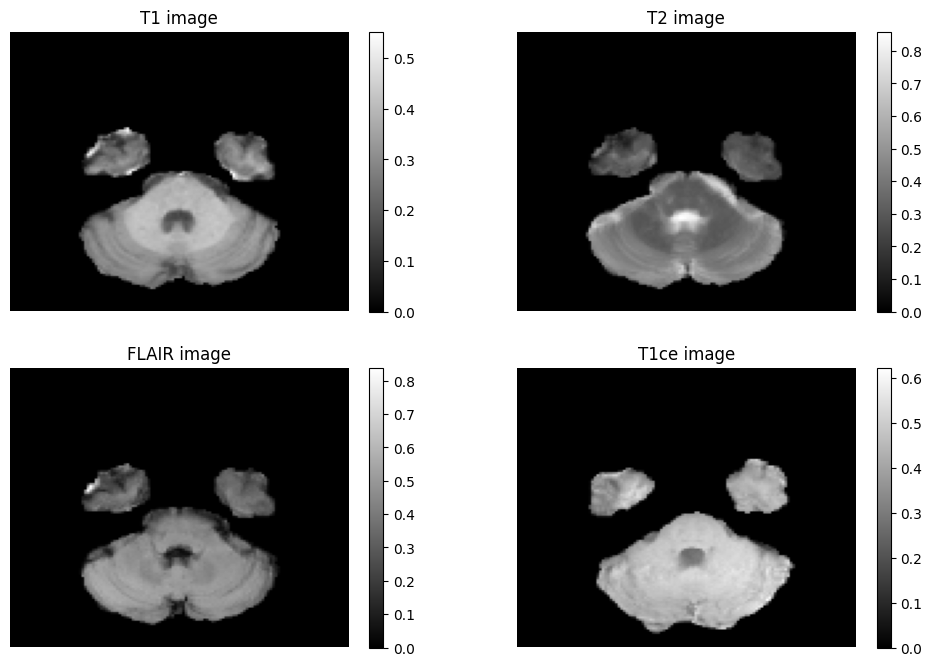

In [7]:
###############################################################################
# 3. LOAD THE PREPROCESSED SAVED DATA #########################################
###############################################################################

import numpy as np
import os
import glob
import pandas as pd
import matplotlib
matplotlib.use('Agg', force=True)
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# Load the processed and saved data and visualize for sanity check.
train_img_t1_t2_fl_dir = output_folder + "train/images_t1_t2_fl/"
train_img_t1ce_dir = output_folder +"train/images_t1ce/"

train_img_t1_t2_fl_list = os.listdir(train_img_t1_t2_fl_dir)
train_img_t1ce_list = os.listdir(train_img_t1ce_dir)

num_images = len(os.listdir(train_img_t1ce_dir))
# Load a single image
img_num = random.randint(0, num_images-1)
test_img_t1_t2_fl = np.load(train_img_t1_t2_fl_dir+train_img_t1_t2_fl_list[img_num])
test_img_t1ce = np.load(train_img_t1ce_dir+train_img_t1ce_list[img_num])

print("Used memory to store test_img_t1_t2_fl: ", test_img_t1_t2_fl.nbytes/(1024*1024), "MB")
print("Used memory to store test_img_t1ce: ", test_img_t1ce.nbytes/(1024*1024), "MB")

# Plot
slice_numb = random.randint(0, test_img_t1ce.shape[2])
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(test_img_t1_t2_fl[:,:,slice_numb,0], cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight'), plt.axis('off')
plt.subplot(222)
plt.imshow(test_img_t1_t2_fl[:,:,slice_numb,1], cmap='gray')
plt.colorbar(), plt.title('T2 image'), plt.axis('tight'), plt.axis('off')
plt.subplot(223)
plt.imshow(test_img_t1_t2_fl[:,:,slice_numb,2], cmap='gray')
plt.colorbar(), plt.title('FLAIR image'), plt.axis('tight'), plt.axis('off')
plt.subplot(224)
plt.imshow(test_img_t1ce[:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image'), plt.axis('tight'), plt.axis('off')
plt.show()

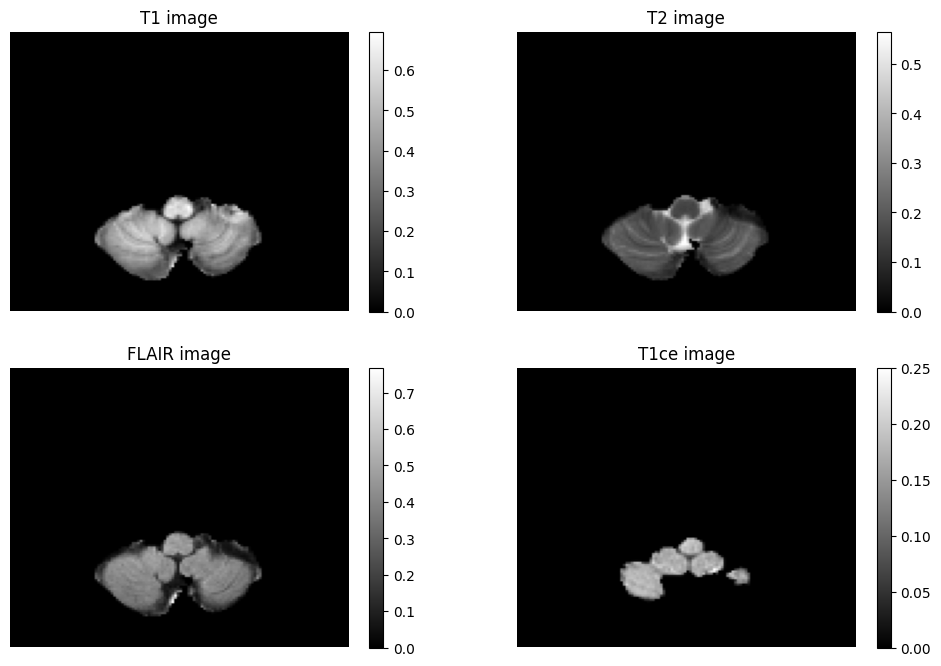

In [8]:
###############################################################################
# 4. DEFINE DATA GENERATOR ####################################################
###############################################################################
import numpy as np
import random
import matplotlib
matplotlib.use('Agg', force=True)
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


def load_img(img_dir, img_list):
    images = []
    for i, image_name in enumerate(img_list):
        if image_name.split('.')[1] == 'npy':
            image = np.load(img_dir+image_name)
            images.append(image)
    images = np.array(images)
    return images


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)
    # keras needs the generator infinite, so we will use while true
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])
            yield (X,Y) # a tuple with two numpy arrays with batch_size samples
            batch_start += batch_size
            batch_end += batch_size


# Define the image generators for training and validation
train_img_t1_t2_fl_dir = output_folder + "train/images_t1_t2_fl/"
train_img_t1ce_dir = output_folder +"train/images_t1ce/"

val_img_t1_t2_fl_dir = output_folder + "val/images_t1_t2_fl/"
val_img_t1ce_dir = output_folder + "val/images_t1ce/"

train_img_t1_t2_fl_list = os.listdir(train_img_t1_t2_fl_dir)
train_img_t1ce_list = os.listdir(train_img_t1ce_dir)

val_img_t1_t2_fl_list = os.listdir(val_img_t1_t2_fl_dir)
val_img_t1ce_list = os.listdir(val_img_t1ce_dir)

batch_size = 4
train_img_datagen = imageLoader(train_img_t1_t2_fl_dir, train_img_t1_t2_fl_list,
                                train_img_t1ce_dir, train_img_t1ce_list, batch_size)
val_img_datagen = imageLoader(val_img_t1_t2_fl_dir, val_img_t1_t2_fl_list, val_img_t1ce_dir,
                              val_img_t1ce_list, batch_size)

# Verify generator
img_t1_t2_fl, img_t1ce = train_img_datagen.__next__()

img_num = random.randint(0, img_t1ce.shape[0]-1)
test_img_t1_t2_fl = img_t1_t2_fl[img_num]
test_img_t1ce = img_t1ce[img_num]

# Plot
slice_numb = random.randint(0, test_img_t1ce.shape[2])
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(test_img_t1_t2_fl[:,:,slice_numb,0], cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight'), plt.axis('off')
plt.subplot(222)
plt.imshow(test_img_t1_t2_fl[:,:,slice_numb,1], cmap='gray')
plt.colorbar(), plt.title('T2 image'), plt.axis('tight'), plt.axis('off')
plt.subplot(223)
plt.imshow(test_img_t1_t2_fl[:,:,slice_numb,2], cmap='gray')
plt.colorbar(), plt.title('FLAIR image'), plt.axis('tight'), plt.axis('off')
plt.subplot(224)
plt.imshow(test_img_t1ce[:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image'), plt.axis('tight'), plt.axis('off')
plt.show()

In [9]:

###############################################################################
# 5. BUILD THE MODEL ARCHITECTURE #############################################
###############################################################################

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, UpSampling3D, BatchNormalization, Dropout, Activation, add
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


# 3D U-Net
def build_3DUNet_model(img_height, img_width, img_depth, img_channels):
    """ 3D Standard U-NET Architecture
     :param input_shape: (image height, image width, image depth, image channels)
     :return: model
     """
    inputs = Input((img_height, img_width, img_depth, img_channels))
    ini_numb_of_filters = 16
    s = inputs

    """ Contraction path """
    c1 = Conv3D(ini_numb_of_filters, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(s)
    c1 = Dropout(0.10)(c1)
    c1 = Conv3D(ini_numb_of_filters, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c1)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)

    c2 = Conv3D(ini_numb_of_filters * 2, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(p1)
    c2 = Dropout(0.15)(c2)
    c2 = Conv3D(ini_numb_of_filters * 2, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c2)
    p2 = MaxPooling3D(pool_size=(2, 2, 2))(c2)

    c3 = Conv3D(ini_numb_of_filters * 4, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(p2)
    c3 = Dropout(0.20)(c3)
    c3 = Conv3D(ini_numb_of_filters * 4, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c3)
    p3 = MaxPooling3D(pool_size=(2, 2, 2))(c3)

    c4 = Conv3D(ini_numb_of_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(p3)
    c4 = Dropout(0.25)(c4)
    c4 = Conv3D(ini_numb_of_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    """ Bridge """
    c5 = Conv3D(ini_numb_of_filters * 16, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(p4)
    c5 = Dropout(0.30)(c5)

    c5 = Conv3D(ini_numb_of_filters * 16, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c5)

    """ Expansive path """
    # u6 = UpSampling3D(size=(2, 2, 2), data_format="channels_last")(c5)
    u6 = Conv3DTranspose(ini_numb_of_filters * 8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(ini_numb_of_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(u6)
    c6 = Dropout(0.25)(c6)
    c6 = Conv3D(ini_numb_of_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c6)

    # u7 = UpSampling3D(size=(2, 2, 2), data_format="channels_last")(c6)
    u7 = Conv3DTranspose(ini_numb_of_filters * 4, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(ini_numb_of_filters * 4, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(u7)
    c7 = Dropout(0.20)(c7)
    c7 = Conv3D(ini_numb_of_filters * 4, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c7)

    # u8 = UpSampling3D(size=(2, 2, 2), data_format="channels_last")(c7)
    u8 = Conv3DTranspose(ini_numb_of_filters * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(ini_numb_of_filters * 2, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(u8)
    c8 = Dropout(0.15)(c8)
    c8 = Conv3D(ini_numb_of_filters * 2, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c8)

    # u9 = UpSampling3D(size=(2, 2, 2), data_format="channels_last")(c8)
    u9 = Conv3DTranspose(ini_numb_of_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(ini_numb_of_filters, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(u9)
    c9 = Dropout(0.10)(c9)
    c9 = Conv3D(ini_numb_of_filters, kernel_size=(3, 3, 3), strides=(1, 1, 1),
                padding='same', activation='relu', kernel_initializer='he_uniform')(c9)

    outputs = Conv3D(1, kernel_size=(1, 1, 1), strides=(1, 1, 1), activation='relu')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    # compile model outside of this function to make it flexible.
    # model.summary()
    return model


# Test if everything is working ok.
model = build_3DUNet_model(128, 128, 128, 3)
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 1)


In [10]:
# Dense_dilated-Residual U-Net
def res_conv_block(x, size, dropout):
    """ Residual convolutional layer """
    # Either put activation function before the addition with shortcut
    # or after the addition (which would be as proposed in the original resNet).
    # 1. conv-Activation-conv-Activation-shortcut-shortcut
    # 2. conv-Activation-conv-shortcut-shortcut-Activation
    conv = Conv3D(size, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                  kernel_initializer='he_uniform')(x)
    conv = Activation('relu')(conv)
    conv = Conv3D(size, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                  kernel_initializer='he_uniform')(conv)
    # conv = Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = Dropout(dropout)(conv)
    shortcut = Conv3D(size, kernel_size=(1, 1, 1), strides=(1, 1, 1),
                      padding='same', kernel_initializer='he_uniform')(x)
    res_path = add([shortcut, conv])
    res_path = Activation('relu')(res_path)  # Activation after addition with shortcut (Original residual block)
    return res_path


def build_res_dilated_3DUNet_model(img_height, img_width, img_depth, img_channels):
    """ 3D Residual U-NET Architecture
     :param input_shape: (image height, image width, image depth, image channels)
     :return: model
     """
    inputs = Input((img_height, img_width, img_depth, img_channels))
    ini_numb_of_filters = 16
    s = inputs

    """ Contraction path """
    c1 = res_conv_block(s, ini_numb_of_filters, dropout=0.10)
    p1 = MaxPooling3D(pool_size=(2, 2, 2))(c1)

    c2 = res_conv_block(p1, ini_numb_of_filters * 2, dropout=0.15)
    p2 = MaxPooling3D(pool_size=(2, 2, 2))(c2)

    c3 = res_conv_block(p2, ini_numb_of_filters * 4, dropout=0.20)
    p3 = MaxPooling3D(pool_size=(2, 2, 2))(c3)

    """ Bridge """
    c51 = Conv3D(ini_numb_of_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                 dilation_rate=(1, 1, 1), activation='relu', kernel_initializer='he_uniform')(p3)
    c51 = Dropout(0.25)(c51)

    c52 = Conv3D(ini_numb_of_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                 dilation_rate=(2, 2, 2), activation='relu', kernel_initializer='he_uniform')(c51)
    c52 = Dropout(0.25)(c52)

    conc = concatenate([c51, c52])
    c55 = Conv3D(ini_numb_of_filters * 8, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
                 dilation_rate=(5, 5, 5), activation='relu', kernel_initializer='he_uniform')(conc)
    c55 = Dropout(0.25)(c55)

    """ Expansive path """
    # u7 = UpSampling3D(size=(2, 2, 2), data_format="channels_last")(c55)
    u7 = Conv3DTranspose(ini_numb_of_filters * 4, (2, 2, 2), strides=(2, 2, 2), padding='same')(c55)
    u7 = concatenate([u7, c3])
    c7 = res_conv_block(u7, ini_numb_of_filters * 4, dropout=0.20)

    # u8 = UpSampling3D(size=(2, 2, 2), data_format="channels_last")(c7)
    u8 = Conv3DTranspose(2 * ini_numb_of_filters * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = res_conv_block(u8, ini_numb_of_filters * 2, dropout=0.15)

    # u9 = UpSampling3D(size=(2, 2, 2), data_format="channels_last")(c8)
    u9 = Conv3DTranspose(ini_numb_of_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = res_conv_block(u9, ini_numb_of_filters, dropout=0.10)

    """ Final convolutional layer """
    outputs = Conv3D(1, kernel_size=(1, 1, 1), strides=(1, 1, 1), activation='relu')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    # compile model outside of this function to make it flexible.
    #model.summary()
    return model


# Test if everything is working ok.
model = build_res_dilated_3DUNet_model(128, 128, 128, 3)
#model.summary()
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 1)


In [11]:
###############################################################################
# 6. TRAINING THE MODEL #######################################################
###############################################################################

import time
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import pandas as pd
import matplotlib
matplotlib.use('Agg', force=True)
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.optimizers import SGD, RMSprop, Adam
import tensorflow as tf
import os
import keras
from keras import backend as keras
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


def plot_learning_curve(filepath):
    df = pd.read_csv(filepath)
    df_x, df_yt, df_yv = df.values[:, 0], df.values[:, 2], df.values[:, 5]
    plt.figure(figsize=(5, 4))
    plt.plot(df_x, df_yt)
    plt.plot(df_x, df_yv)
    # plt.title('average training loss and validation loss')
    plt.ylabel('loss', fontsize=16)
    plt.xlabel('epoch', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(['training loss', 'validation loss'], fontsize=14, loc='upper right')
    plt.show()
    return

def L1_loss(y_true, y_pred):
    L1_loss = keras.mean(keras.abs(y_true - y_pred), axis=-1)
    return L1_loss
# L1 loss: MAE; L2 loss: MSE

def L2_loss(y_true, y_pred):
    L2_loss = tf.losses.mean_squared_error(y_true, y_pred)
    return L2_loss
# L2 loss: MSE

def ssim_loss(y_true, y_pred):
    ssim_loss = 1 - (tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0, filter_size=5)))
    return ssim_loss

def custom_loss(y_true, y_pred):
    L1_loss = keras.mean(keras.abs(y_true - y_pred), axis=-1)
    #ssim_loss = 1 - (tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=5)))
    ssim_loss = 1 - (tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=1)))
    total_loss = 1.0 * L1_loss + 1.0 * ssim_loss
    return total_loss


# Compile the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=0.2, patience=6, min_lr=0.00000001)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)  # SGD
metrics = ['mae', 'mse']

# model = build_3DUNet_model(img_height=128, img_width=128, img_depth=128, img_channels=3)
model = build_res_dilated_3DUNet_model(img_height=128, img_width=128, img_depth=128, img_channels=3)

#model.compile(optimizer=optimizer, loss=custom_loss, metrics=metrics)
model.compile(optimizer=optimizer, loss=custom_loss, metrics=metrics)
#print(model.summary())
print(model.input_shape)
print(model.output_shape)

# Hyperparameters
epochs = 50
steps_per_epoch = len(train_img_t1ce_list) // batch_size
val_steps_per_epoch = len(val_img_t1ce_list) // batch_size

# Callbacks
checkpoint_folder = './saved_model/'
if not os.path.exists(checkpoint_folder):
  os.makedirs(checkpoint_folder)

checkpoint_filepath = checkpoint_folder + 'MR_CE_Synth_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
callbacks = [
    EarlyStopping(patience=50, monitor='val_loss', restore_best_weights=False, verbose=1),
    ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True),
    CSVLogger('MR_CE_Synth_3D_logs.csv', separator=',')]
# ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, min_lr=1e-7, verbose=1)


(None, 128, 128, 128, 3)
(None, 128, 128, 128, 1)


(None, 128, 128, 128, 3)
(None, 128, 128, 128, 1)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.2396 - mae: 0.0738 - mse: 0.0234
Epoch 1: val_loss improved from inf to 0.13645, saving model to /saved_model/MR_CE_Synth_best_model.epoch01-loss0.14.hdf5
45/45 [==============================] - 391s 8s/step - loss: 0.2396 - mae: 0.0738 - mse: 0.0234 - val_loss: 0.1365 - val_mae: 0.0477 - val_mse: 0.0102
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.1581 - mae: 0.0533 - mse: 0.0124
Epoch 2: val_loss improved from 0.13645 to 0.12778, saving model to /saved_model/MR_CE_Synth_best_model.epoch02-loss0.13.hdf5
45/45 [==============================] - 15s 327ms/step - loss: 0.1581 - mae: 0.0533 - mse: 0.0124 - val_loss: 0.1278 - val_mae: 0.0451 - val_mse: 0.0091
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.1467 - mae: 0.0498 - mse: 0.0109
Epoch 3: val_loss im

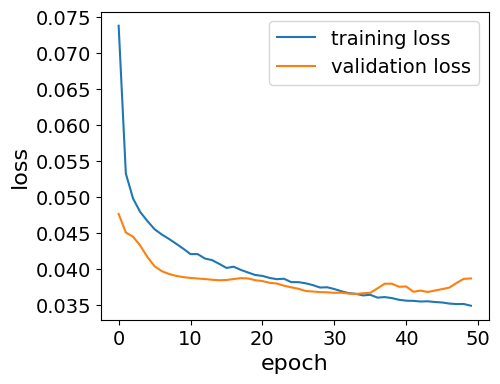

In [12]:
#Load the model for continue training
# model = load_model('saved_model/MR_CE_Synth_best_model.epoch02-loss0.41.hdf5',
#                    custom_objects={'custom_loss': custom_loss})

# print(model.summary())
print(model.input_shape)
print(model.output_shape)

import tensorflow as tf
tf.compat.v1.debugging.set_log_device_placement(True)
print(tf.config.list_physical_devices('GPU'))
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# Fit the model
start = time.time()
with tf.device('/gpu:0'):
  history = model.fit(train_img_datagen,
                      steps_per_epoch=steps_per_epoch,
                      epochs=50,
                      verbose=1,
                      validation_data=val_img_datagen,
                      validation_steps=val_steps_per_epoch,
                      callbacks=[callbacks])

finish = time.time()
print('total exec. time (h)): ', (finish - start) / 3600.)
print('Training has been finished successfully')

# Save the trained model
model.save('saved_model/MR_CE_Synth_3D.hdf5')

# Plot the Learning Curve
filepath = 'MR_CE_Synth_3D_logs.csv'
plot_learning_curve(filepath)

###############################################################################
################################# THE END #####################################
##############################################

In [80]:
###############################################################################
# 1. MAKE PREDICTIONS #########################################################
###############################################################################

import numpy as np
from keras.models import load_model
import matplotlib
matplotlib.use('Agg', force=True)
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

HOME_DIR ='./Data/'
test_folder = HOME_DIR + 'train_val_test_datasets_comb/test/'
# Load the processed and saved test dataset
test_img_t1_t2_fl_dir = test_folder + "images_t1_t2_fl/"
test_img_t1ce_dir = test_folder + "images_t1ce/"

test_img_t1_t2_fl_list = os.listdir(test_img_t1_t2_fl_dir)
test_img_t1ce_list = os.listdir(test_img_t1ce_dir)

# Load the trained model
new_model = load_model('saved_model/MR_CE_Synth_3D.hdf5', compile=False)
#new_model = load_model('saved_model/MR_CE_Synth_3D_plain_unet_customLoss_ep_18.hdf5', compile=False)
#new_model = load_model('saved_model/MR_CE_Synth_3D_dense_dilated_res_unet_customLoss_ep_24.hdf5', compile=False)
#new_model = load_model('saved_model/MR_CE_Synth_3D_dense_dilated_res_unet_customLoss_ep_42_comb.hdf5', compile=False)

# Check the model's architecture
#new_model.summary()

In [14]:
# Deep Learning for Contrast-Enhanced T1 MR Image Synthesis
# @author: Alexander F.I. Osman, April 2023

"""
PART II: TESTING THE MODEL PERFORMANCE

This code demonstrates a 3D Dense-Dlated Res U-Net architecture for contrast-enhanced MR image
synthesis from contrast-free image.

Dataset: BRATS'2021 challenge dataset.

The testing process goes through the following steps:
1. Make predictions on a test dataset
2. Evaluate the model performance (SSIM, MAE, etc.)
"""


# Make predictions on all test set
#### Multi-input
test_t1, test_t2, test_fl = [], [], []
test_pred = []
test_real = []
for item in tqdm(range(0, len(os.listdir(test_img_t1_t2_fl_dir))), desc='Predicting'):
    test_img_t1_t2_fl = np.load(test_img_t1_t2_fl_dir + test_img_t1_t2_fl_list[item])
    test_img_t1ce = np.load(test_img_t1ce_dir + test_img_t1ce_list[item])
    test_img_t1_t2_fl = np.expand_dims(test_img_t1_t2_fl, axis=0)
    prediction = new_model.predict(test_img_t1_t2_fl, verbose=0)
    prediction = np.absolute(prediction[0,:,:,:,0])   # strip" the last dim.
    test_img_t1 = test_img_t1_t2_fl[0,:,:,:,0]
    test_img_t2 = test_img_t1_t2_fl[0,:,:,:,1]
    test_img_fl = test_img_t1_t2_fl[0,:,:,:,2]
    ground_truth = test_img_t1ce[:,:,:,0]
    test_pred.append(prediction)
    test_real.append(ground_truth)
    test_t1.append(test_img_t1)
    test_t2.append(test_img_t2)
    test_fl.append(test_img_fl)
test_t1 = np.array(test_t1)
test_t2 = np.array(test_t2)
test_fl = np.array(test_fl)
test_pred = np.array(test_pred)
test_real = np.array(test_real)


# ### Single-input
# test_t1, test_t2, test_fl = [], [], []
# test_pred = []
# test_real = []
# for item in tqdm(range(0, len(os.listdir(test_img_t1_t2_fl_dir))), desc='Predicting'):
#     test_img_t1_t2_fl = np.load(test_img_t1_t2_fl_dir + test_img_t1_t2_fl_list[item])
#     test_img_t1ce = np.load(test_img_t1ce_dir + test_img_t1ce_list[item])
#     test_img_t1_t2_fl = np.expand_dims(test_img_t1_t2_fl, axis=0)
#     prediction = new_model.predict(test_img_t1_t2_fl[:,:,:,:,0], verbose=0)
#     prediction = np.absolute(prediction[0,:,:,:,0])   # strip" the last dim.
#     test_img_t1 = test_img_t1_t2_fl[0,:,:,:,0]
#     test_img_t2 = test_img_t1_t2_fl[0,:,:,:,1]
#     test_img_fl = test_img_t1_t2_fl[0,:,:,:,2]
#     ground_truth = test_img_t1ce[:,:,:,0]
#     test_pred.append(prediction)
#     test_real.append(ground_truth)
#     test_t1.append(test_img_t1)
#     test_t2.append(test_img_t2)
#     test_fl.append(test_img_fl)
# test_t1 = np.array(test_t1)
# test_t2 = np.array(test_t2)
# test_fl = np.array(test_fl)
# test_pred = np.array(test_pred)
# test_real = np.array(test_real)

Predicting: 100%|██████████| 58/58 [02:41<00:00,  2.78s/it]


In [15]:
test_t1.shape

(58, 128, 128, 128)

(<matplotlib.colorbar.Colorbar at 0x79305047bfa0>,
 Text(0.5, 1.0, 'residual'),
 (-0.5, 127.5, 127.5, -0.5),
 (-0.5, 127.5, 127.5, -0.5))

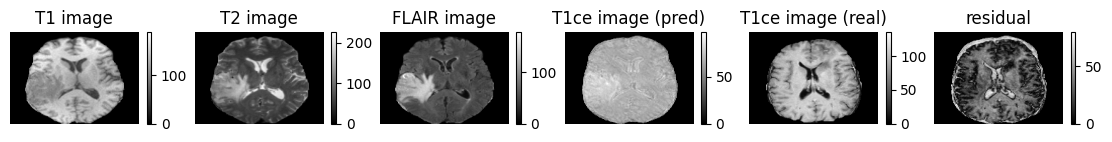

In [16]:
# Plot
plt.figure(figsize=(14, 8))
grid = plt.GridSpec(6, 6, wspace=.15, hspace=.15)
pt_id1 = 5
slice_numb1 = 66
exec (f"plt.subplot(grid{[0]})")
plt.imshow(test_t1[pt_id1,:,:,slice_numb1]*255, cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[1]})")
plt.imshow(test_t2[pt_id1,:,:,slice_numb1]*255, cmap='gray')
plt.colorbar(), plt.title('T2 image'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[2]})")
plt.imshow(test_fl[pt_id1,:,:,slice_numb1]*255, cmap='gray')
plt.colorbar(), plt.title('FLAIR image'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[3]})")
plt.imshow(test_pred[pt_id1,:,:,slice_numb1]*255, cmap='gray')
plt.colorbar(), plt.title('T1ce image (pred)'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[4]})")
plt.imshow(test_real[pt_id1,:,:,slice_numb1]*255, cmap='gray')
plt.colorbar(), plt.title('T1ce image (real)'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[5]})")
plt.imshow(abs(test_real[pt_id1,:,:,slice_numb1] - test_pred[pt_id1,:,:,slice_numb1])*255, cmap='gray')
plt.colorbar(), plt.title('residual'), plt.axis('tight'), plt.axis('off')

In [17]:
###############################################################################
# 2. EVALUATE THE MODEL PERFORMANCE  ##########################################
###############################################################################
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, hausdorff_distance, \
    mean_squared_error, normalized_mutual_information, normalized_root_mse
from tqdm import tqdm
import matplotlib
matplotlib.use('Agg', force=True)
%matplotlib inline
import matplotlib.pyplot as plt


# Compute the SSIM, MAE, MSE, PSNR between two images.
psnr = np.zeros(test_pred.shape[0] * test_pred.shape[3]).astype('float32')
ssim = np.zeros(test_pred.shape[0] * test_pred.shape[3]).astype('float32')
mae = np.zeros(test_pred.shape[0] * test_pred.shape[3]).astype('float32')
mse = np.zeros(test_pred.shape[0] * test_pred.shape[3]).astype('float32')
hdd = np.zeros(test_pred.shape[0] * test_pred.shape[3]).astype('float32')
nmi = np.zeros(test_pred.shape[0] * test_pred.shape[3]).astype('float32')
nrmse = np.zeros(test_pred.shape[0] * test_pred.shape[3]).astype('float32')

for item in tqdm(range(len(test_pred)), desc='Computing eval. metrics'):
    pred = test_pred[item]
    real = test_real[item]
    for j in range(len(pred)):
        psnr[j+(item*128)] = np.array(peak_signal_noise_ratio(real[:,:,j], pred[:,:,j], data_range=None))
        ssim_val, ssim_map = structural_similarity(real[:,:,j], pred[:,:,j], data_range=1, full=True)
        ssim_val = np.array(ssim_val)
        ssim[j+(item*128)] = ssim_val
        mae[j+(item*128)] = abs(real[:,:,j] - pred[:,:,j]).mean()
        mse[j+(item*128)] = mean_squared_error(real[:,:,j], pred[:,:,j])
        hdd[j+(item*128)] = hausdorff_distance(real[:,:,j], pred[:,:,j])
        nmi[j+(item*128)] = normalized_mutual_information(real[:,:,j], pred[:,:,j])
        nrmse[j+(item*128)] = normalized_root_mse(real[:,:,j], pred[:,:,j])

psnr = psnr[np.logical_not(np.isnan(psnr))]
psnr = psnr[np.isfinite(psnr)]
mean_psnr, std_psnr = np.mean(psnr), np.std(psnr)
print("PSNR (dB) =", np.round(mean_psnr, 4), "±", np.round(std_psnr, 4))
ssim = ssim[np.logical_not(np.isnan(ssim))]
ssim = ssim[np.isfinite(ssim)]
mean_ssim, std_ssim = np.mean(ssim), np.std(ssim)
print("SSIM =", np.round(mean_ssim, 4), "±", np.round(std_ssim, 4))
mae = mae[np.logical_not(np.isnan(mae))]
mae = mae[np.isfinite(mae)]
mean_mae, std_mae = np.mean(mae), np.std(mae)
print("MAE =", np.round(mean_mae, 4), "±", np.round(std_mae, 4))
mse = mse[np.logical_not(np.isnan(mse))]
mse = mse[np.isfinite(mse)]
mean_mse, std_mse = np.mean(mse), np.std(mse)
print("MSE =", np.round(mean_mse, 4), "±", np.round(std_mse, 4))
hdd = hdd[np.logical_not(np.isnan(hdd))]
hdd = hdd[np.isfinite(hdd)]
mean_hdd, std_hdd = np.mean(hdd), np.std(hdd)
print("HDD =", np.round(mean_hdd, 4), "±", np.round(std_hdd, 4))
nmi = nmi[np.logical_not(np.isnan(nmi))]
nmi = nmi[np.isfinite(nmi)]
mean_nmi, std_nmi = np.mean(nmi), np.std(nmi)
print("NMI =", np.round(mean_nmi, 4), "±", np.round(std_nmi, 4))
nrmse = nrmse[np.logical_not(np.isnan(nrmse))]
nrmse = nmi[np.isfinite(nrmse)]
mean_nrmse, std_nrmse = np.mean(nrmse), np.std(nrmse)
print("NRMSE =", np.round(mean_nrmse, 4), "±", np.round(std_nrmse, 4))

Computing eval. metrics:   2%|▏         | 1/58 [00:02<01:54,  2.01s/it]/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:261: RuntimeWarning: invalid value encountered in double_scalars
  return (H0 + H1) / H01
/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:108: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(mean_squared_error(image_true, image_test)) / denom
Computing eval. metrics:   5%|▌         | 3/58 [00:06<01:55,  2.11s/it]/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:108: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(mean_squared_error(image_true, image_test)) / denom
Computing eval. metrics: 100%|██████████| 58/58 [02:00<00:00,  2.07s/it]

PSNR (dB) = 23.0437 ± 3.4206
SSIM = 0.7025 ± 0.1062
MAE = 0.0371 ± 0.0177
MSE = 0.006 ± 0.0035
HDD = 8.9227 ± 6.5226
NMI = 1.1939 ± 0.0544
NRMSE = 1.1947 ± 0.053


In [18]:
np.min(mae)

0.0

In [19]:
locs = np.where((mae<0.1) & (mae >0))
locs = np.array(locs)
locs[np.where((locs%128.0 >30) & (locs%128.0 <100))]

array([  31,   32,   33, ..., 7393, 7394, 7395])

In [20]:
print("SSIM =", np.round(mean_ssim, 4), "±", np.round(std_ssim, 4))

SSIM = 0.7025 ± 0.1062


In [21]:
ssim[252]

1.0

In [42]:
def rand_generate(range_max):
  runm = True
  while(runm):
    NUM = np.random.randint(range_max)
    if((NUM%128) > 50 & (NUM%128) < 65):
      return NUM
      break

49 8
SSIM val = 0.824
40 53
SSIM val = 0.615
30 38
SSIM val = 0.663


0.042072907

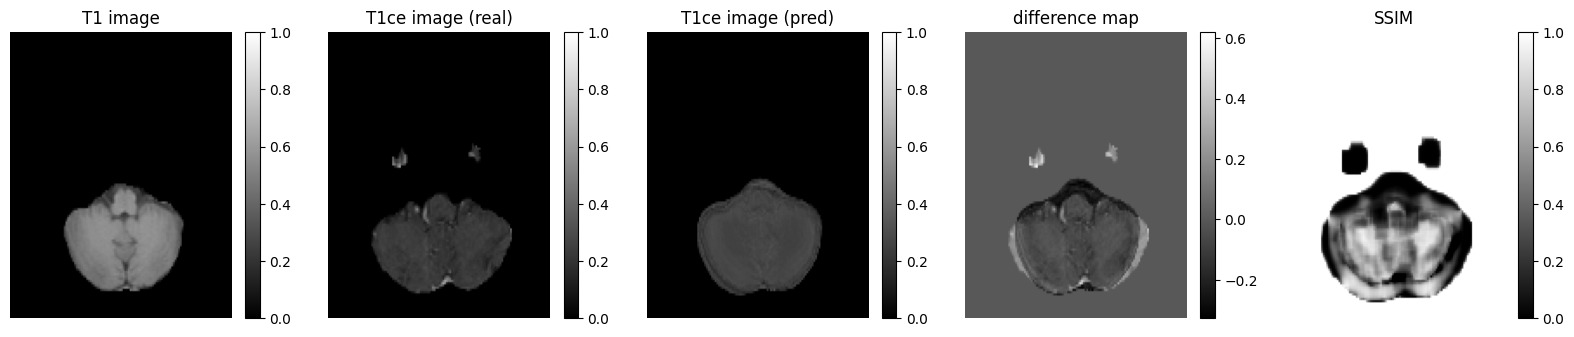

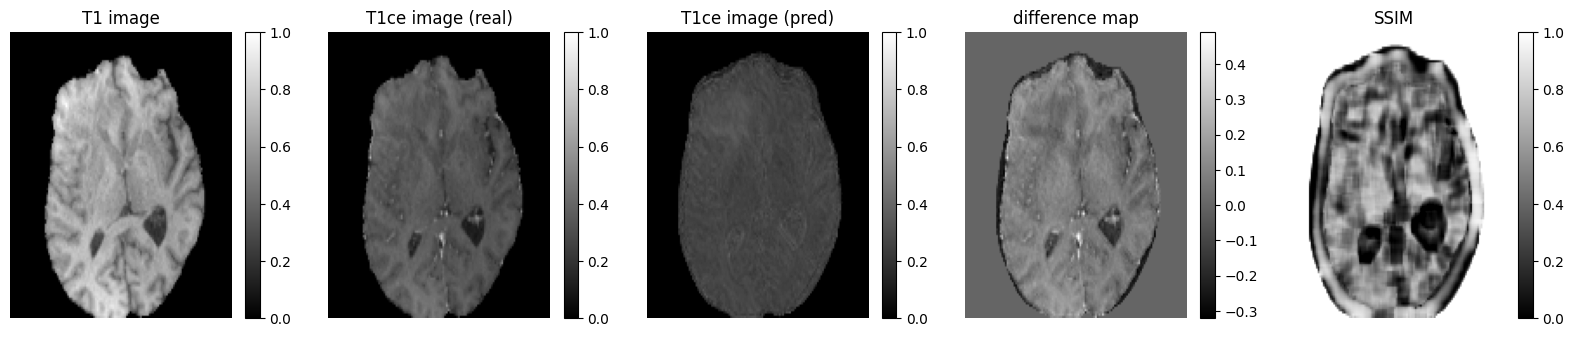

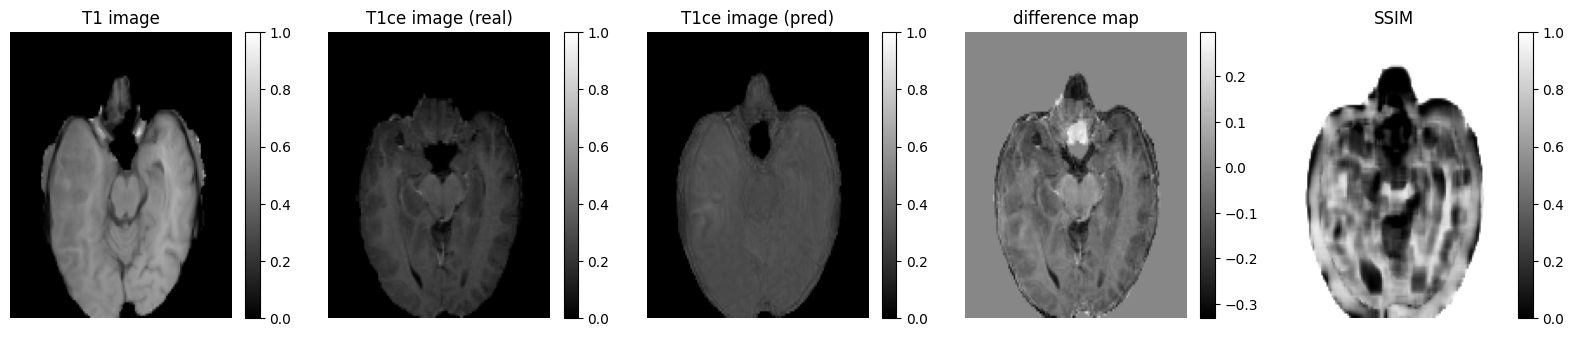

In [81]:
# Plot
# NUM = 50

NUM = rand_generate(58*128)
#NUM = 30
pt_id = NUM//128
slice_numb = NUM%128
plt.figure(figsize=(20, 8))
grid = plt.GridSpec(2, 5, wspace=.15, hspace=.15)
exec (f"plt.subplot(grid{[0]})")
plt.imshow(test_t1[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[1]})")
plt.imshow(test_real[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (real)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[2]})")
plt.imshow(test_pred[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (pred)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[3]})")
residual = test_real[pt_id, :,:,slice_numb] - test_pred[pt_id,:,:,slice_numb]
plt.imshow(residual, cmap='gray')
plt.colorbar(), plt.title('difference map'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[4]})")
ssim_val, ssim_map = structural_similarity(real[:,:,j], pred[:,:,j], data_range=1, full=True)

ssim_matrix = structural_similarity(test_real[pt_id,:,:,slice_numb], test_pred[pt_id,:,:,slice_numb], data_range=1, full=True)
print(pt_id, slice_numb)
print("SSIM val =", np.round(ssim_matrix[0], 3))
plt.imshow(ssim_matrix[1], cmap='gray')
plt.colorbar(), plt.title('SSIM'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)

NUM = rand_generate(58*128)
pt_id = NUM//128
slice_numb = NUM%128
plt.figure(figsize=(20, 8))
grid = plt.GridSpec(2, 5, wspace=.15, hspace=.15)
exec (f"plt.subplot(grid{[0]})")
plt.imshow(test_t1[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[1]})")
plt.imshow(test_real[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (real)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[2]})")
plt.imshow(test_pred[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (pred)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[3]})")
residual = test_real[pt_id, :,:,slice_numb] - test_pred[pt_id,:,:,slice_numb]
plt.imshow(residual, cmap='gray')
plt.colorbar(), plt.title('difference map'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[4]})")
ssim_matrix = structural_similarity(test_real[pt_id,:,:,slice_numb], test_pred[pt_id,:,:,slice_numb], data_range=1, full=True)
print(pt_id, slice_numb)
print("SSIM val =", np.round(ssim_matrix[0], 3))
plt.imshow(ssim_matrix[1], cmap='gray')
plt.colorbar(), plt.title('SSIM'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
abs(test_real[pt_id,:,:,slice_numb] - test_pred[pt_id,:,:,slice_numb]).mean()


NUM = rand_generate(58*128)
pt_id = NUM//128
slice_numb = NUM%128
plt.figure(figsize=(20, 8))
grid = plt.GridSpec(2, 5, wspace=.15, hspace=.15)
exec (f"plt.subplot(grid{[0]})")
plt.imshow(test_t1[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[1]})")
plt.imshow(test_real[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (real)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[2]})")
plt.imshow(test_pred[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (pred)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[3]})")
residual = test_real[pt_id, :,:,slice_numb] - test_pred[pt_id,:,:,slice_numb]
plt.imshow(residual, cmap='gray')
plt.colorbar(), plt.title('difference map'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[4]})")
ssim_matrix = structural_similarity(test_real[pt_id,:,:,slice_numb], test_pred[pt_id,:,:,slice_numb], data_range=1, full=True)
print(pt_id, slice_numb)
print("SSIM val =", np.round(ssim_matrix[0], 3))
plt.imshow(ssim_matrix[1], cmap='gray')
plt.colorbar(), plt.title('SSIM'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
abs(test_real[pt_id,:,:,slice_numb] - test_pred[pt_id,:,:,slice_numb]).mean()

48 47
SSIM val = 0.653


0.030121667

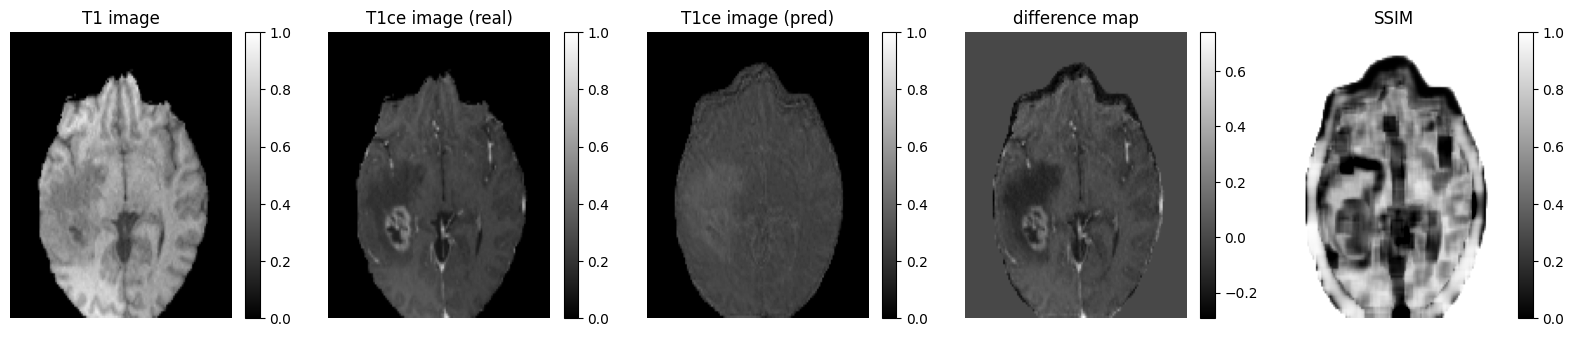

In [82]:
pt_id = 48
slice_numb = 47
plt.figure(figsize=(20, 8))
grid = plt.GridSpec(2, 5, wspace=.15, hspace=.15)
exec (f"plt.subplot(grid{[0]})")
plt.imshow(test_t1[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1 image'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[1]})")
plt.imshow(test_real[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (real)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[2]})")
plt.imshow(test_pred[pt_id,:,:,slice_numb], cmap='gray')
plt.colorbar(), plt.title('T1ce image (pred)'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
exec (f"plt.subplot(grid{[3]})")
residual = test_real[pt_id, :,:,slice_numb] - test_pred[pt_id,:,:,slice_numb]
plt.imshow(residual, cmap='gray')
plt.colorbar(), plt.title('difference map'), plt.axis('tight'), plt.axis('off')
exec (f"plt.subplot(grid{[4]})")
ssim_matrix = structural_similarity(test_real[pt_id,:,:,slice_numb], test_pred[pt_id,:,:,slice_numb], data_range=1, full=True)
print(pt_id, slice_numb)
print("SSIM val =", np.round(ssim_matrix[0], 3))
plt.imshow(ssim_matrix[1], cmap='gray')
plt.colorbar(), plt.title('SSIM'), plt.axis('tight'), plt.axis('off'), plt.clim(0, 1)
abs(test_real[pt_id,:,:,slice_numb] - test_pred[pt_id,:,:,slice_numb]).mean()